# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
def plot_result(t, x, u):
    # we can plot the results
    plt.figure()

    plt.subplot(2,1,1)
    plt.plot(t, x[0,:])
    plt.legend(['theta'])

    plt.subplot(2,1,2)
    plt.plot(t, x[1,:])
    plt.legend(['omega'])

    # we can also plot the control
    plt.figure()
    plt.plot(t[:-1], u.T)
    plt.legend(['u1'])
    plt.xlabel('Time [s]')


def plot_value_fn_policy(pendulum_object, q_table_star):
    value_function, policy = pendulum_object.get_policy_and_value_function(q_table_star)

    # we plot the value function
    plt.figure(figsize=[6,6])
    plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    # we plot the policy
    plt.figure(figsize=[6,6])
    plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')


In [4]:
class QLearning:

    def __init__(self, control_list):
        self.control_list = control_list
        self.epsilon = 0.1

        self.max_episodes = 10000
        self.max_iterations = 100 #t

        self.alpha = 0.99
        self.lr_rate = 0.1 #gamma

        # we generate 50 equally spaced points for theta and omega
        self.discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
        self.discretized_omega = np.linspace(-6, 6, 50)

        self.total_cost = []
        self.total_td_error = []

    
    def get_cost(self, x, u):
        theta = x[0]
        omega = x[1]
        alpha = 0.99
        g_xu = ((theta - np.pi)*(theta - np.pi)) + (0.01*omega*omega) + (0.0001*u*u)
        # cost = alpha*g_x_u
        return g_xu

    
    def get_discritized_state(self, theta, omega):
        # now given an arbitrary continuous state theta
        theta_arbitrary = theta
        omega_arbitrary = omega

        # find the index of the closest element in the set of discretized states
        index_in_discretized_theta = np.argmin(np.abs(self.discretized_theta - theta_arbitrary))
        index_in_discretized_omega = np.argmin(np.abs(self.discretized_omega - omega_arbitrary))
        
        return index_in_discretized_theta, index_in_discretized_omega

    
    def q_learning(self, q_table):
        
        # total_cost = []
        # total_td_error = []
        for episode in range(self.max_episodes):
            x0 = np.array([0., 0.])  
            cost_value = 0
            td_error_value = 0

            for t in range(self.max_iterations):
                theta_0 = x0[0]
                omega_0 = x0[1]

                # get a discritize state space index for 
                theta_d_idx, omega_d_idx = self.get_discritized_state(theta_0, omega_0)

                # get a random number between 0 to 1
                # Epsilon-greedy policy

                if np.random.uniform() > self.epsilon:
                    control_idx = q_table[theta_d_idx, omega_d_idx, :].argmin()
                    control = self.control_list[control_idx]
                else:
                    control_idx = np.random.randint(0, len(self.control_list))
                    control = self.control_list[control_idx]

                # compute cost 
                g_xu = self.get_cost(x0, control)

                # get next state
                x1 = pendulum.get_next_state(x0, control)
                theta_1 = x1[0]
                omega_1 = x1[1]

                # get a discritize state space index for 
                theta1_d_idx, omega1_d_idx = self.get_discritized_state(theta_1, omega_1)

                Q_xt_u = q_table[theta1_d_idx, omega1_d_idx, :].min()
                Q_x_u = q_table[theta_d_idx, omega_d_idx, control_idx]

                # compute TD error
                td_error = g_xu + self.alpha*Q_xt_u - Q_x_u

                # get new Q value at t
                q_table[theta_d_idx, omega_d_idx, control_idx] = Q_x_u + self.lr_rate*td_error

                x0 = x1

                cost_value += abs(g_xu)
                td_error_value += abs(td_error)

            self.total_cost.append(cost_value)
            self.total_td_error.append(td_error_value)

        return q_table

    
    def get_policy_and_value_function(self, q_table):
        # Q(x,u)
        value_function = np.zeros([50,50])

        # control
        policy = np.zeros([50,50])

        for i in range(50):
            for j in range(50):
                value_function[i,j] = q_table[i, j, :].min()
                idx = q_table[i, j, :].argmin()
                policy[i,j] = self.control_list[idx]
                
        return value_function, policy

    def plot_loss_td_error(self):
        plt.figure(figsize=[10,10])

        t = np.arange(start=0, stop=len(self.total_cost), step=1)
        
        kernel_size = 100
        kernel = np.ones(kernel_size) / kernel_size

        plt.subplot(2,1,1)
        plt.plot(self.total_cost)
        plt.legend(['cost'])
        total_cost_mv  = np.convolve(self.total_cost, kernel, mode='same')
        plt.plot(total_cost_mv)
        plt.legend(['cost'])

        plt.subplot(2,1,2)
        plt.plot(self.total_td_error)
        plt.legend(['td_error'])
        total_td_error_mv  = np.convolve(self.total_td_error, kernel, mode='same')
        plt.plot(total_td_error_mv)
        plt.legend(['td_error'])



### Part 1: Control [-4, 0, 4]

In [5]:
# pendulum with (-4,0,4)
control_list1 = np.array([-4, 0, 4]) 

pendulum1 = QLearning(control_list=control_list1)

q_table = np.zeros([50,50,3])
q_table_star = pendulum1.q_learning(q_table)


In [6]:
def dummy_controller(x):
    theta = x[0]
    omega = x[1]

    # get a discritize state space index for 
    theta_d_idx, omega_d_idx = pendulum1.get_discritized_state(theta, omega)

    control_idx = q_table_star[theta_d_idx, omega_d_idx, :].argmin()
    control = pendulum1.control_list[control_idx]

    return control

# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
# x0 = np.array([1.4,0.])
x0 = np.array([0. ,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABiIG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTMgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAKGmWI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAK6sc+imSBhd68YAAm4ABbuM5kKeCZ4A
KLncy42RoxMT5JvQKiH2KEUVHmKOXJTJ0xtq3MiVQ64aXHD0U+g9yzKJrBEYVpiPM7q5ljmcs9qk
0UbRq0h2QD1gXQOsqj2KacYfjLJCVwKmmxPP6gfvE8Ntl+e/CeYH5vYUEp6ib5QkZJtOQ0RNNMz1
dN9i5Q6ttel/XWuB6Ot/75arv5ueuw9wAH3yM2ii2+CmydnQatYUelsaBPRmSb+NZlUSRRQN79Hg
l5JcGAYIMVSoYtbH4taELx8gBWPaBrqzGaPE4Zj8EOm6EKmgShIJEEmW8RDKTilPK5u0L8vEG7sB
zxTGTlnadJ+EQf4oukkL1zmBpjYS/A4+8z1/Q8POnTJx5nTod9mZFAfW4LaVg+IPnoe9S4x4Djrl
E39Ox2nBAUkG+W1c9xGNOML0KRT2933LKD4u46Fa3FgZD/VZcx+9jzXHtH6WCNd438LihMQ2RggP
oSA4phFeKgvW/qd7YLmKc5P+rWVfnnQRE3VSAye1ztKL88K1w9TF/p4fhsX64ngwTAqoAAC9Boln
OpUPUqTF8TdP3j87vJApF/EqXr0ZJVqAo8XhZowgGYazm2QFWd1qV7F9QUUv1P7mXrDhzbK2xIFQ
wOm0awstr8vzhWbNdlpgBx9jfA0PT2yuzfNRX2xIXbcaG1PGbLRwLa5S8TR6GIAV44s0fMcOjTA4
HS2CfgHxCWY8YulsopvOpwfxuvMeNgiYIWzZ7Y/rpi6Jbrcy2I195YH3T5e06ObkpqOvct9k+liN
Tq+6YccSzkibEoiDS1xKXMadPVGB99MCN4ckMLVr7ivs+LnSZ4rdlBn/0pZY22RknrH+CM4+DP5A
P1dainwFrVrt1R1o5GAMPVaVdRAAAAMAACk/1+MU21d9qM3ELBSX/uuGJgK3q0qqzDGZPI6GZaKN
LSrEp7DYcULIIPVDsJdd2vmnydfiisgnzWTCX1oCJnWIMlVjccL4gVWVP+/l3WEGMT1B8bzuveg/
P7Xsyel6GGwOALc5AMuuurTcViwwCpaF30vLrILt4egKOuEPN9AlB1zzv9QupQyUlQ7cWC6Yh1au
5gF4CHInVtNU6Jxhx44f1c9LCV7t3RD8PI+FNXXrUOf84v/K1HFC5VRpt63QpuBI2sbDWpZhuVrQ
2c6alJRZ9TJ52y9ZUlUqjWdPAcnJ8nDqn7j3ebSiedrYYjQVWDdiY0iqHo/mVSxRb4a+YBiAd0VI
HVLTdynbbNNFyZtIeYUeh9tPktPoROyXPgOj+DptpaMmfbOvsSkWC9WANc81m3W/zvCDgAAAAwNS
Wc3pHRyedAZd0AkASbXCCx7RvQ3mQjWrnESs9C0z3/8JNMoZVHwXFvESbwboBhWgfMX83onsCsuv
Vateb2dheBpp474ZhQ2VWQQgKuHD0wEsDOpXa2zCejlhg6RJ41mNdlmVRd4QCTCagcl6+Oy/Fqka
NE3Nrw1FThITzdzc9gzd8flVN/NnBz8DQ0j84AWgmueZKscbpYY0h16Hc7CVxPKPeB5yTE9rNKG2
H+PJ+Bw70OVkRXbO02MApPihx6axwE/TUVsc3FWRjx29EC/n2QRno+Biq73La4aKCReE6F600I2C
IoopdbQMOcS6OaJzNh0tvQob/wbMeUppqMADD/IiychvDQlbYf/7qKKLbD/VQlGk89u7oDCF0eYU
fygx+gFWbPVyGp70QLYGB+yhw1jVUVjeoAmvMmqGpDYnxbDt2d2enAADaOYgAAC8sHm1ojzB+Lf8
2Iu8sd1XYeMJFZfNG/EGcBiFH/Okbw03iRIp5KP2ZaAMAmSyyplJY6CDdpGK1+P227sSnO0AdoOl
YGt3M5UmGwq/59ejfbG2QtfTunavWB9CoTzavhicQWjtbDkHVzccGLcZL7vs0nUiImQFciRvJIY5
MTme9ao+4uoMkJjFnrWAghLc7g07iXqyyBq8V3u+I1sz1QFPCPMUfN5XM5kCvIi//9hmso9hsh/G
Ltewwx3eFYGtIVMor9ljtiHsk1IOpNM+xhjTdRu4nX9HQil781iXmhGDSR72zSsztwiDivHWDbD/
80dLAQG3zweWXJ9xcmPgHiREwy+ULrMwuTRf509iNzHCvNXaVaZsIlSxcjirh5oOjThDAVmJvFHn
t5ujCmjSpyr3SWhl6OJ6fGaujXIsstJH7VzEtPIb7JteV6R6YqcUg8fU6PhMAAJ4ENfICccy4syi
huEDGHlT4gk8POPGG4OldPQ5D+Dyar5KsSdohFbvASY4VCz/4kcFj+TGLZUegtTrUfyizPQZOFSs
t3c0KK1gzOuKLFMP27j317ROvrgeGAekcVpz7GtcK4fzY/LPrcqRcGZ1xRjq+L460IsyvI9heESS
ZcWut41zIjUHizbrD+KyJKJNTTslKk0WaiqDcARjzAsz1e0AlWszH8KkHDq8lUTFTrQWV+vxcADy
rvGhE+TpEgOauIES6njGS/h2kOd7Kdg+s1ZkS2S4qe2MmURN0NbdQnHmb+1qIL0lWIuLR+q+B98N
7lkpyJLSWMwiRrnwpq92yyImktjwYYObKK5LcE7a2CfozU1fCMjg5GHT2kop79mu3yWGidgjlbCb
SFh5Pd8nxC0rHBEB291PWjICuDQVhGp0uC8NoTg2x+5aFeaCoObo1JRGeR3oePF5pzxKY2K9BTS+
7mvZXjSVyExyYoJrqj25w5wEGC1B6s8AYByFWXCll2eBTSHAZ7biZm44DMzcvLtmTpw7OOvRVIMy
v2MQOEW5vRGvtkMBa0xtU5CBpoZB9qVFlgy5x+nmqXroWyr+P19Uq+UgT0wF4LWxTmeGpjM9iSSb
fiUqAlDTIKaFNvrXHaMiE

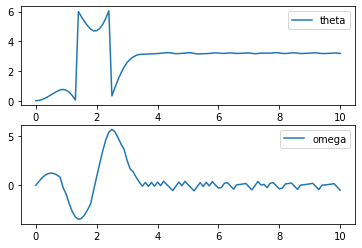

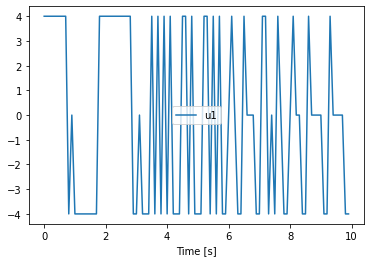

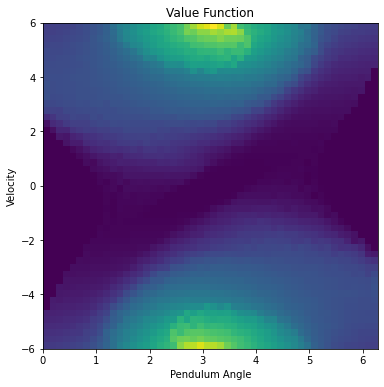

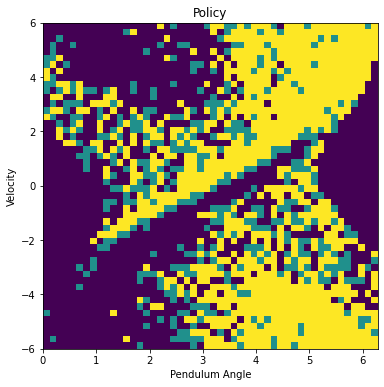

In [7]:
plot_result(t, x, u)
plot_value_fn_policy(pendulum_object=pendulum1, q_table_star=q_table_star)

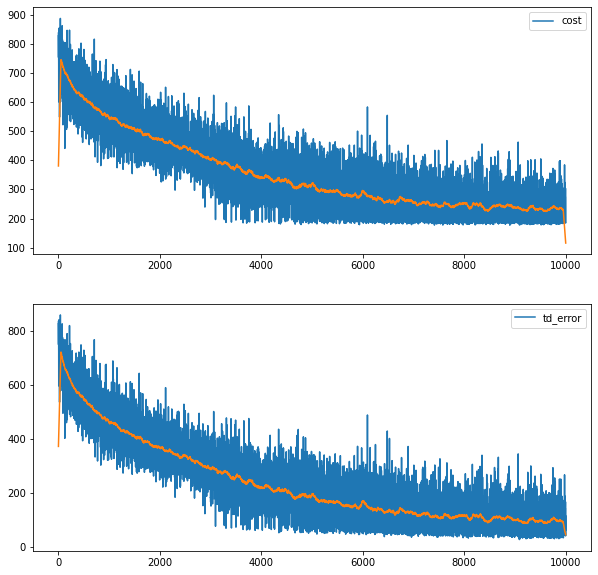

In [8]:
pendulum1.plot_loss_td_error()

### Part 2: Control [-5, 0, 5]

In [9]:
# pendulum with (-5,0,5)
control_list2 = np.array([-5, 0, 5]) 

pendulum2 = QLearning(control_list=control_list2)

q_table = np.zeros([50,50,3])
q_table_star = pendulum2.q_learning(q_table)

In [10]:
def dummy_controller(x):
    theta = x[0]
    omega = x[1]

    # get a discritize state space index for 
    theta_d_idx, omega_d_idx = pendulum2.get_discritized_state(theta, omega)

    control_idx = q_table_star[theta_d_idx, omega_d_idx, :].argmin()
    control = pendulum2.control_list[control_idx]

    return control

# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0. ,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABWfW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTMgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAKK2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAzdiJ7g8K10PRXgACAgAFE5HmQp4K/g
AbPhU6RJh8T38MNwRklczQkE+BQepx/4wlXyCtuP/oJ7E0OapqRwlVfks2f+TbvRA+WMfDH2PBez
eBpBtGb8vQyXgXUVvFR01KlIBJsXLKhCJnpl2sGxVaRFLj9yFceknoMd5pXPTYRzQNCHnoRK2kcA
VBVpvVbnlJL3xYQH3CGsui/ZDNd/BkUvc2iXUhn3B6ShADivv8RvPXTz638mZnaBTZmSb+NZvhcN
ghS9+jwS8kuDFmx4IyoMM3jaA03OF/toi87czOngggiRliIEkvJqv5OBKEgkQSZbxHGDgUp5XN2h
fl4kn4tCaJE2x75Y6T8Ig/xRdIaLXoknSEGcUrCxZwisy0s6i/HHmdOh32ZkUB9bgxqWXRbnNIHG
kQWvK6fJeMZjGtrIGGWmbPTTgzf9S6+sD7IZOyp3+tKTRCs2yy1d6ew2wKYNNOw/5mccNw7SWqX+
vigW8QThKkRhnBtfGWVmVSCfaWxG6nk91BiTjODct5utUlKGo0O2AyUO54oHvrSy98HzyJVeAAAD
AECCH7my+c0wU3KNV1/4rX5rRWC5heWoD8LU3bv9+kVuf8jw0XUXpu8+PXFTNBuvRXutzv3WOCY6
k3aDmWvuZtSwoRZbYpLzG7xnmi1hokNBQAufT2yuzfNRX2xIXblUEhyCuAaLZMZ6GIAV44szGMOa
NMDgdBheNpBGJJ9VJj1NTJgKAZnd9aAENNISMEdlmH+lkdhXcO4Nl273uX9v7EXzjQ+p98NSsnjX
5c8Z0UL1rWxoSa5fmz97zoYbE7lHeqKvUnvckpLSilA8185WlDsDN1u6jGMsh8YiuRa0ZwYvt2sT
VRB6mVrFMll4iyk8uXkVgEDmLlbOZIB6AAADADYtBRj57MtouH7BOwH2b6a6H6ABV3LB3ANhOAiZ
JPFsBY3F09hsOKFj9f80i5nd0QgbA347u9hySayYTSd4J+wvexGUP9L/dBb6I+SYWhOBM0wUULKe
C96D8/tezJ6XoYZ3D/9UJgeOCryX8+Z2j+djylvwAw3K5Hf9f9cIeb6BKDroHGnl1KO9mhvOiwXT
EOrV3Ll2Rn6k7fYW82Tyx7K3C0oD3UV5mw+0+rKQpUr8OhFYTyLx0WYTaS6XzvBOQhbq7vNTV4q+
bjebYU7iiipO9S8eapwEkAfWfIqqY//RADNcgGPCRWgHigceKxXyrYGezVPpuqdSUnR1jeX1F8ZI
UJEyaBqljAzdSeUCishjYDWDisZ+JDE6HhSadAETxKHA/xJNicmGrPph0Qr/P+lcDvq2JG7eyiaP
AOQDz7++AS2AjNGHU+6AAAADACpytgtCucd4PZHwC27GEkF8yG//3UlehzmvguN8F9J3qfiz+hG3
/b+E6zgbqyZ4D04lKJiGEuKy/Rma2V1aptuR8gNaHYM6krUmoOm2WGDpEnjWpiROIT9/0e7U+/94
Zp2JL40t9caJubYaCRhXQnm7m57Bm74+q2qlGbDiXjQ0j82wWgmueZKscbpV4awh4YO7tMnAZQED
SriS5MndW9jxSdbnh3ocrIiu2dpuWjUNPt7YKrcXi+F7kdxVkYMdvRAv59kEZ6PgZZlOP2jniITS
MO++2mj78uiwNgh2VKm+I/sNexP8zZIXnaKzR+66T0cDhuKFvy+Vo1PU9iulf/psF6cMZvH4STfT
S8OmlI4fbLDQypPvYlWLhg2Oepnz55Hz1KZgktRFQ5nLezcP/ach5psbnxdpHi9DN/tAoyAB1qB+
ADX5n67Uan8nhExx4BtUpHp1KRISbPKDtTLEfgxLRkOKcX/oYXaieH7xzD8bfkW6eYZLLKmSnaZE
N8A7onf6VcnlBEEAVvkc93sjKTAbTMJdoUcId2+NTRFzm9G3ksD6FQnm1fDE4gtHLaHIOrm44MW4
yX3fWodpERMgK5EjeSQRL8yFb0xnU4ILzITGLNZROjga7C2UywVntsb4ok5XohrZnqgKeEeB/qx9
1PwTeeh7DZD+MXa9hhdeX6HZLjjdL3w2O2IewC7B0tafYwyTOIrPnzHPOUcFIgbMTSpJmRv3ejcl
SUM6P//NRpQhThiSDwyeAsj5Glxcn2xZW25bJETDKh0Z8fGcm2UQZ9+/ucgU7uiOO7IX+hYzJLrP
031WOItCex09YXlIseyharYPEBe6X3wxmn71FyluqwG+fdGfsoEkZBJuhzRnzPTNMPtYCEyYXx9b
uX1V5PhOQM5+2HRTY5i7ZKOgfPGNH0XlgEL4s6w0MPP7XHdqQxpM4cStdF3TV4PyRcGZ1xR0Wj/E
+zqtjpUO1qmzQDqFZ0xj72hfCqI0dAVITRcGZ1xRz5VacZnn/USLzTMQe/sSlqVme3IZAEAaUJUJ
ouDM64orvLmDIshNa17fPwAsz1hczrJ6EZmz8kpL7KR/K6yFSacmKRyLK9yWF3D29kYuxxdqUcEs
z4LtSNZt1h/FZD4tWx2d6B5ecVC4kwwAYLLyESBvRJVf9p/U/XfscJiKN95VOXFT3FfWHFWS7fcM
RF6M7sLzY82xLi0frCSH3wLzVhL+n3jgNnZF+Emnmac4UoALYVH21HN7/ZLcE7a2CfoiIbTmYM+y
QVti6etTEddmvC2cAxUi9R5NkO644Ozh2rYRI4Uzf+PANajG3eRaAx3AWgRGszwtvGrdZFdpsAEN
fnFfA+Gb/MPh69vwAvdP06sc/ELqr2f5ubIq6oCJXcXORljnxOacfC3exkjitAIUSfIISQcoa+pq
crf+2in9YiuI/7tE7hE5Snq5Q7Qc3izacI5ehs8ssOmC1kTYtIchH1eLyUGvfSmaKes4UWWvgUF/
H6+qVfKQJ6iPYA2ce8zw1

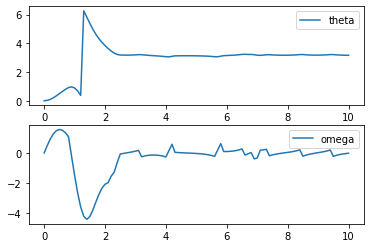

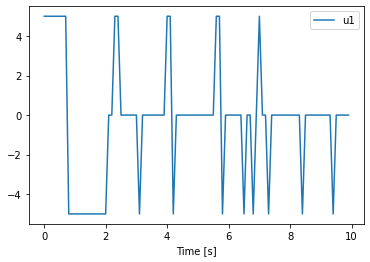

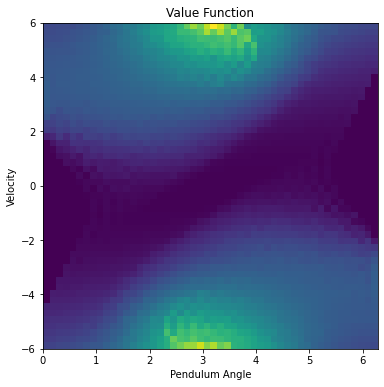

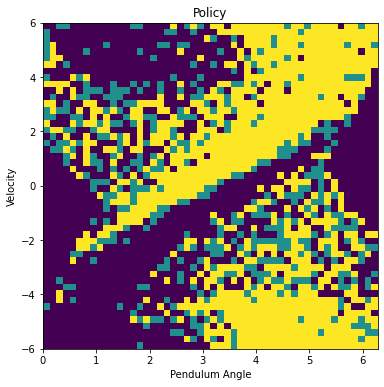

In [11]:
plot_result(t, x, u)
plot_value_fn_policy(pendulum_object=pendulum1, q_table_star=q_table_star)

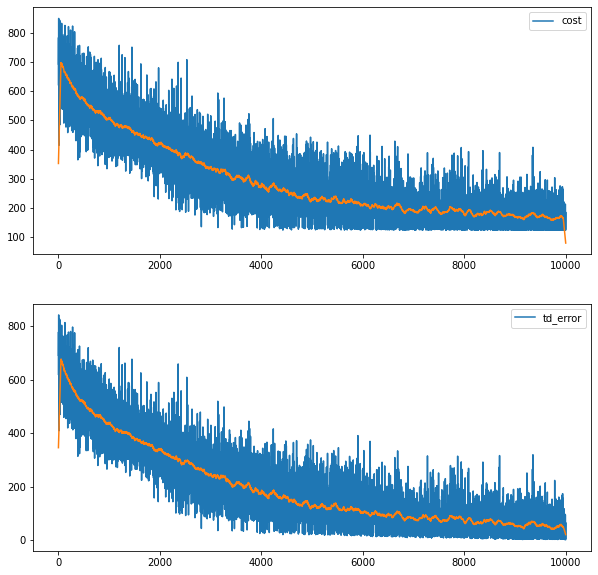

In [12]:
pendulum2.plot_loss_td_error()